# QUESTION 1:

# Importing the required libraries.

In [ ]:
import torch
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import Counter



# Data Loading

In [ ]:
                                                                                # To Define the path to my data file
file_path = '/content/drive/MyDrive/NLP/WEEK4/sentiment labelled sentences/amazon_cells_labelled.txt'

                                                                                # Loading the dataset into a pandas DataFrame
dataset = pd.read_csv(file_path, sep='\t', header=None, names=['Sentence', 'Label'])

                                                                                # To ensure it's loaded correctly
print(dataset.head())


                                            Sentence  Label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1


# Splitting the data into two variables

In [ ]:
                                                                                # Separate the reviews and labels
reviews = dataset['Sentence']
labels = dataset['Label']
                                                                                # Remove punctuation from reviews
reviews_cleaned = reviews.apply(lambda review: review.translate(str.maketrans('', '', string.punctuation)))

                                                                                # Verify the cleaned reviews
print(reviews_cleaned.head())


0    So there is no way for me to plug it in here i...
1                            Good case Excellent value
2                                Great for the jawbone
3    Tied to charger for conversations lasting more...
4                                     The mic is great
Name: Sentence, dtype: object


# Creating Vocabulary

In [ ]:
                                                                                # Tokenize the reviews into words
tokenized_reviews = reviews_cleaned.apply(lambda review: review.split())
                                                                                # Flatten the list of words and count the occurrences of each word
all_words = [word for review in tokenized_reviews for word in review]
                                                                                # Create the vocabulary (unique words)
vocabulary = list(set(all_words))
                                                                                # Check the size of the vocabulary and print first 10 words
print(f"Vocabulary size: {len(vocabulary)}")
print(f"First 10 words in vocabulary: {vocabulary[:10]}")


Vocabulary size: 2220
First 10 words in vocabulary: ['somewhere', 'flawed', 'most', 'stereo', 'lineanother', 'comments', 'superfast', 'Fits', '11', 'EXCELLENT']


# Creating Dictionary(Key-value pairs)

In [ ]:
                                                                                # Create a dictionary that maps each word in the vocabulary to an integer index
word_to_int = {word: idx for idx, word in enumerate(vocabulary)}

                                                                                # Check the first 10 entries in the dictionary
print(list(word_to_int.items())[:10])


[('somewhere', 0), ('flawed', 1), ('most', 2), ('stereo', 3), ('lineanother', 4), ('comments', 5), ('superfast', 6), ('Fits', 7), ('11', 8), ('EXCELLENT', 9)]


# Encoding the Data

In [ ]:
                                                                                # Encode the review data
encoded_reviews = reviews_cleaned.apply(lambda review: [word_to_int[word] for word in review.split() if word in word_to_int])

                                                                                # Check the first few encoded reviews
print(encoded_reviews.head())


0    [669, 816, 1326, 264, 171, 1720, 1536, 1943, 2...
1                              [1709, 1904, 579, 1205]
2                             [2207, 1720, 1076, 1392]
3    [243, 1943, 132, 1720, 1301, 1530, 176, 71, 10...
4                               [1085, 172, 1326, 267]
Name: Sentence, dtype: object


# LSTM Model Architecture of Network.

In [ ]:
import torch
import torch.nn as nn

class SentimentLSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, output_dim=1, n_layers=3):
        super(SentimentLSTMNet, self).__init__()
                                                                                        # Embedding layer: Converts word indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

                                                                                        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)

                                                                                        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

                                                                                        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
                                                                                        # Pass the input through the embedding layer
        embedded = self.embedding(x)

                                                                                        # Pass through LSTM layers
        lstm_out, (hidden, cell) = self.lstm(embedded)

                                                                                        # Take the last output of the LSTM
        lstm_last_output = lstm_out[:, -1, :]

                                                                                        # Pass through fully connected layer and apply sigmoid
        output = self.sigmoid(self.fc(lstm_last_output))

        return output


# Specifing the Parameters and passing to model.

In [ ]:
                                                                                # Parameters
vocab_size = len(vocabulary)                                                    # Total number of unique words in the dataset
embedding_dim = 64
hidden_dim = 128
output_dim = 1                                                                   # Binary classification
n_layers = 3                                                                     # Number of LSTM layers

                                                                                # Initialize the model
model = SentimentLSTMNet(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

                                                                                # Print the model architecture
print(model)


SentimentLSTMNet(
  (embedding): Embedding(2220, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Defining Loss Function

In [ ]:
                                                                                # Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

                                                                                # Number of epochs to train for
num_epochs = 10


# Trainig and calculating the accuracy

In [ ]:
import torch
import matplotlib.pyplot as plt
                                                                                # Ensure the labels are converted to a tensor
labels_tensor = torch.tensor(labels.values).float()
                                                                                # Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []
                                                                                # Training loop
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_reviews = len(encoded_reviews)

    for i, review in enumerate(encoded_reviews):
                                                                                # Convert the review to a tensor
        review_tensor = torch.tensor(review).unsqueeze(0)                       # Add batch dimension
                                                                                # Reset the gradients
        optimizer.zero_grad()
                                                                                # Perform a prediction
        prediction = model(review_tensor)
                                                                                # Calculate the loss
        loss = loss_function(prediction.squeeze(), labels_tensor[i])
                                                                                # Backpropagate the loss and update the parameters
        loss.backward()
        optimizer.step()
                                                                                # Accumulate the total loss
        total_loss += loss.item()
                                                                                # Compute accuracy (prediction > 0.5 means positive sentiment)
        if (prediction.squeeze().item() > 0.5 and labels_tensor[i] == 1) or \
           (prediction.squeeze().item() <= 0.5 and labels_tensor[i] == 0):
            correct_predictions += 1
                                                                                # Calculate the average loss and accuracy for this epoch
    avg_loss = total_loss / total_reviews
    accuracy = correct_predictions / total_reviews * 100
                                                                                # Store the loss and accuracy values
    loss_values.append(avg_loss)
    accuracy_values.append(accuracy)
                                                                                # Print the metrics for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/10, Loss: 0.6719, Accuracy: 59.80%
Epoch 2/10, Loss: 0.5936, Accuracy: 69.00%
Epoch 3/10, Loss: 0.4851, Accuracy: 78.20%
Epoch 4/10, Loss: 0.3847, Accuracy: 83.20%
Epoch 5/10, Loss: 0.2312, Accuracy: 91.50%
Epoch 6/10, Loss: 0.1438, Accuracy: 94.50%
Epoch 7/10, Loss: 0.0770, Accuracy: 97.70%
Epoch 8/10, Loss: 0.0487, Accuracy: 99.00%
Epoch 9/10, Loss: 0.0629, Accuracy: 98.10%
Epoch 10/10, Loss: 0.0589, Accuracy: 98.60%


# Visualising the progress of Loss function and Accuracy

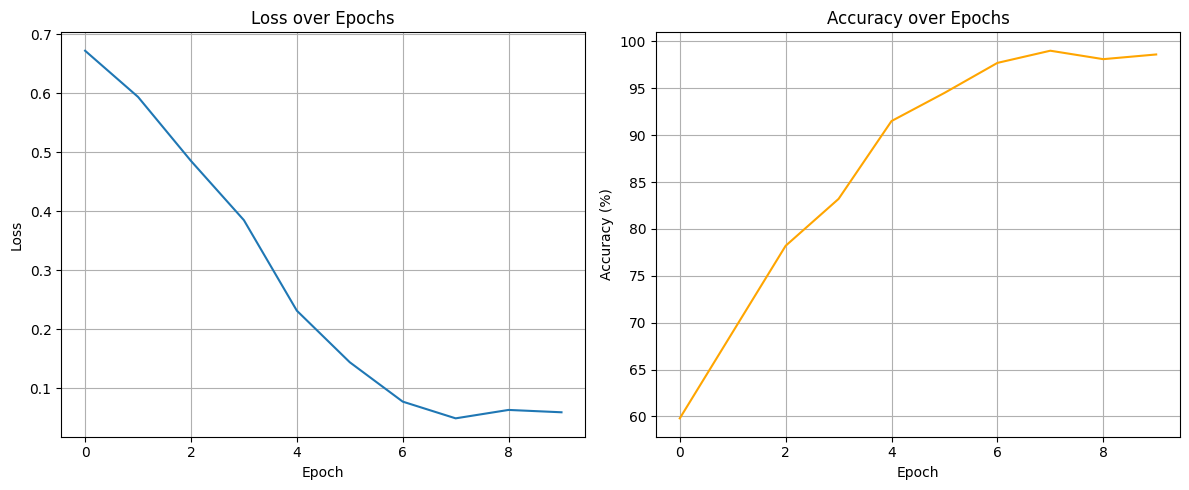

In [ ]:
                                                                                # Plot the loss and accuracy over time
plt.figure(figsize=(12, 5))
                                                                                # Loss Plot
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
                                                                                # Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


# QUESTION 2:

# Replacing the punctuation with Empty space.

In [ ]:
import string
sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front
suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on-
road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270-horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines,
and crawling across boulder-strewn trails."""

                                                                                # To Create a translation table that maps all punctuation to None
translator = str.maketrans('', '', string.punctuation)

                                                                                # Using the translation table to remove punctuation
cleaned_sentence = sentence.translate(translator)

                                                                                # Print the cleaned sentence
print(cleaned_sentence)


The larger Broncos will be available with 35inch offroad tires and will be able 
to drive through water nearly 3 feet 10 inches deep It has independent front 
suspension unlike its main competitor the Jeep Wrangler Independent suspension used 
on almost all modern passenger vehicles generally provides a smoother ride and better on
road handling than a single solid axle It still has a solid axle in the back though like most 
pickup trucks a design suited to hard use Like the Wrangler both the two and fourdoor 
Bronco will have a removable roofs and doors Buyers will be able to choose either a hard 
roof that can be removed in sections a cloth top or both Unlike the Wrangler though the 
Broncos doors will fit inside the vehicle after being removed The Bronco will be available 
with a choice of either a 10speed automatic or sevenspeed manual transmission The 
manual transmission will have six gears for ordinary driving plus a seventh for low speed 
offroad driving It will be powered by ei

# Removing multiple space and replace with single.

In [ ]:
                                                                                # Remove multiple spaces by splitting and joining
cleaned_sentence_single_space = ' '.join(cleaned_sentence.split())

                                                                                # Print the cleaned sentence
print(cleaned_sentence_single_space)


The larger Broncos will be available with 35inch offroad tires and will be able to drive through water nearly 3 feet 10 inches deep It has independent front suspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides a smoother ride and better on road handling than a single solid axle It still has a solid axle in the back though like most pickup trucks a design suited to hard use Like the Wrangler both the two and fourdoor Bronco will have a removable roofs and doors Buyers will be able to choose either a hard roof that can be removed in sections a cloth top or both Unlike the Wrangler though the Broncos doors will fit inside the vehicle after being removed The Bronco will be available with a choice of either a 10speed automatic or sevenspeed manual transmission The manual transmission will have six gears for ordinary driving plus a seventh for low speed offroad driving It will be powered by either a 270

# Remove Single characters.

In [ ]:
                                                                                # Split the sentence into words
words = cleaned_sentence_single_space.split()

                                                                                # Remove words that are a single character
cleaned_sentence_no_single_chars = ' '.join([word for word in words if len(word) > 1])

                                                                                # Print the cleaned sentence
print(cleaned_sentence_no_single_chars)


The larger Broncos will be available with 35inch offroad tires and will be able to drive through water nearly feet 10 inches deep It has independent front suspension unlike its main competitor the Jeep Wrangler Independent suspension used on almost all modern passenger vehicles generally provides smoother ride and better on road handling than single solid axle It still has solid axle in the back though like most pickup trucks design suited to hard use Like the Wrangler both the two and fourdoor Bronco will have removable roofs and doors Buyers will be able to choose either hard roof that can be removed in sections cloth top or both Unlike the Wrangler though the Broncos doors will fit inside the vehicle after being removed The Bronco will be available with choice of either 10speed automatic or sevenspeed manual transmission The manual transmission will have six gears for ordinary driving plus seventh for low speed offroad driving It will be powered by either 270horsepower 23liter turbo

# Case Convertion To Lower case

In [ ]:
                                                                                # Convert the text to all lowercase
cleaned_sentence_lower = cleaned_sentence_no_single_chars.lower()

                                                                                # Print the lowercase sentence
print(cleaned_sentence_lower)


the larger broncos will be available with 35inch offroad tires and will be able to drive through water nearly feet 10 inches deep it has independent front suspension unlike its main competitor the jeep wrangler independent suspension used on almost all modern passenger vehicles generally provides smoother ride and better on road handling than single solid axle it still has solid axle in the back though like most pickup trucks design suited to hard use like the wrangler both the two and fourdoor bronco will have removable roofs and doors buyers will be able to choose either hard roof that can be removed in sections cloth top or both unlike the wrangler though the broncos doors will fit inside the vehicle after being removed the bronco will be available with choice of either 10speed automatic or sevenspeed manual transmission the manual transmission will have six gears for ordinary driving plus seventh for low speed offroad driving it will be powered by either 270horsepower 23liter turbo

# Split the text into individual words or tokens

In [ ]:
                                                                                # Split the text into individual words
words_list = cleaned_sentence_lower.split()

                                                                                # Print the list of words
print(words_list)


['the', 'larger', 'broncos', 'will', 'be', 'available', 'with', '35inch', 'offroad', 'tires', 'and', 'will', 'be', 'able', 'to', 'drive', 'through', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'it', 'has', 'independent', 'front', 'suspension', 'unlike', 'its', 'main', 'competitor', 'the', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'on', 'almost', 'all', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'and', 'better', 'on', 'road', 'handling', 'than', 'single', 'solid', 'axle', 'it', 'still', 'has', 'solid', 'axle', 'in', 'the', 'back', 'though', 'like', 'most', 'pickup', 'trucks', 'design', 'suited', 'to', 'hard', 'use', 'like', 'the', 'wrangler', 'both', 'the', 'two', 'and', 'fourdoor', 'bronco', 'will', 'have', 'removable', 'roofs', 'and', 'doors', 'buyers', 'will', 'be', 'able', 'to', 'choose', 'either', 'hard', 'roof', 'that', 'can', 'be', 'removed', 'in', 'sections', 'cloth', 'top', 'or', 'both', 'unlike', 'the', 'wrangler', 'th

# Installing the NLTK Package

In [ ]:
pip install nltk


# Remove the Stopwords.

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

                                                                                # Load English stop words
stop_words = set(stopwords.words('english'))

                                                                                # Remove stop words from the list of words
filtered_words = [word for word in words_list if word not in stop_words]

                                                                                # Print the filtered list of words
print(filtered_words)


['larger', 'broncos', 'available', '35inch', 'offroad', 'tires', 'able', 'drive', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'independent', 'front', 'suspension', 'unlike', 'main', 'competitor', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'almost', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'better', 'road', 'handling', 'single', 'solid', 'axle', 'still', 'solid', 'axle', 'back', 'though', 'like', 'pickup', 'trucks', 'design', 'suited', 'hard', 'use', 'like', 'wrangler', 'two', 'fourdoor', 'bronco', 'removable', 'roofs', 'doors', 'buyers', 'able', 'choose', 'either', 'hard', 'roof', 'removed', 'sections', 'cloth', 'top', 'unlike', 'wrangler', 'though', 'broncos', 'doors', 'fit', 'inside', 'vehicle', 'removed', 'bronco', 'available', 'choice', 'either', '10speed', 'automatic', 'sevenspeed', 'manual', 'transmission', 'manual', 'transmission', 'six', 'gears', 'ordinary', 'driving', 'plus', 'seventh', 'low', 'speed', 'offroad', 'dri

# To Tokenize, Stem, and Lemmatize the text

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')                                                        # For WordNet lemmatizer
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

                                                                                # Tokenization
tokens = word_tokenize(cleaned_sentence_lower)

                                                                                # Stemming
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in tokens]

                                                                                # Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

                                                                                # Print the results
print("Tokenized words:", tokens)
print("Stemmed words:", stemmed_words)
print("Lemmatized words:", lemmatized_words)


Tokenized words: ['the', 'larger', 'broncos', 'will', 'be', 'available', 'with', '35inch', 'offroad', 'tires', 'and', 'will', 'be', 'able', 'to', 'drive', 'through', 'water', 'nearly', 'feet', '10', 'inches', 'deep', 'it', 'has', 'independent', 'front', 'suspension', 'unlike', 'its', 'main', 'competitor', 'the', 'jeep', 'wrangler', 'independent', 'suspension', 'used', 'on', 'almost', 'all', 'modern', 'passenger', 'vehicles', 'generally', 'provides', 'smoother', 'ride', 'and', 'better', 'on', 'road', 'handling', 'than', 'single', 'solid', 'axle', 'it', 'still', 'has', 'solid', 'axle', 'in', 'the', 'back', 'though', 'like', 'most', 'pickup', 'trucks', 'design', 'suited', 'to', 'hard', 'use', 'like', 'the', 'wrangler', 'both', 'the', 'two', 'and', 'fourdoor', 'bronco', 'will', 'have', 'removable', 'roofs', 'and', 'doors', 'buyers', 'will', 'be', 'able', 'to', 'choose', 'either', 'hard', 'roof', 'that', 'can', 'be', 'removed', 'in', 'sections', 'cloth', 'top', 'or', 'both', 'unlike', 'the'

# Sentiment Analysis of text

In [ ]:
pip install textblob


In [ ]:
from textblob import TextBlob
text = cleaned_sentence_lower
                                                                                # Create a TextBlob object
blob = TextBlob(text)
                                                                                # Get the sentiment
sentiment = blob.sentiment
                                                                                # Print sentiment analysis
print(f"Polarity (Sentiment): {sentiment.polarity}")                            # -1 (negative) to 1 (positive)
print(f"Subjectivity: {sentiment.subjectivity}")                                # 0 (objective) to 1 (subjective)


Polarity (Sentiment): 0.12333123865381931
Subjectivity: 0.39980100544616676


**Interpretation:**

The text has a **slightly positive sentiment** with a polarity of **0.1233**, indicating mild positive language. Its **subjectivity score of 0.3998** suggests it is **mostly objective**, containing more factual information with some opinions. Overall, it provides balanced descriptions with a slight positive bias towards the subject.